Import libraries

In [1]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape
import fiona
import os
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

Save the working directory with data and where you will write the outputs.

In [2]:
wd = "D:/4.LS/MEDPZ/semestralka/final/3+"
rootdir = wd + "/snimek"

Walk through the folder with downloaded satellite imagery and save the B03 and B11 20 m bands into a list named ```source```.

In [3]:
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if(os.path.join(subdir, file).endswith("B03_20m.jp2") or os.path.join(subdir, file).endswith("B11_20m.jp2")):
            source.append(os.path.join(subdir, file))

source

['D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20200713T103031_N0214_R108_T32TMS_20200713T132504.SAFE\\GRANULE\\L2A_T32TMS_A026417_20200713T103703\\IMG

Fill two lists ```unique_dates``` and ```sorted_source``` with dates of the downloaded satellite images and with their full paths and names respectively.

In [4]:
unique_dates = []
sorted_source = []

# loop through the bands in list source
for item in source:
    # find a date in the band name using regular expression
    match = re.search(r'S2A_[A-Za-z\d]+_(\d+)T', item)
    # if there is a date in the band name
    if match:
        date = match.group(1)
        # if the date is unique
        if date not in unique_dates:
            # add date to the list unique_dates
            unique_dates.append(date)
            # add band to the list sorted_source
            sorted_source.append(item)

unique_dates

['20180701', '20190716', '20200713', '20210718', '20220713']

In [5]:
sorted_source

['D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20200713T103031_N0214_R108_T32TMS_20200713T132504.SAFE\\GRANULE\\L2A_T32TMS_A026417_20200713T103703\\IMG_DATA\\R20m\\T32TMS_20200713T103031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20210718T103031_N0301_R108_T32TMS_20210718T133950.SAFE\\GRANULE\\L2A_T32TMS_A031708_20210718T103025\\IMG_DATA\\R20m\\T32TMS_20210718T103031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20220713T103041_N0400_R108_T32TMS_20220713T164557.SAFE\\GRANULE\\L2A_T32TMS_A036856_20220713T103035\\IMG

Read geojson file with the area of interest polygon using fiona.open() function. Save its geometry into the ```geometry``` variable. Then create a shape from it and save it in the variable ```input_polygon```.

In [6]:
with fiona.open(wd + "/aoi/aoiled.geojson", "r") as shapefile:
    geometry = shapefile[0]["geometry"]
    input_polygon = shape(geometry)

geometry

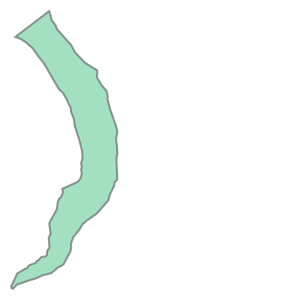

In [7]:
input_polygon

Define 4 empty lists.

In [10]:
out_image = []
out_transform = []
out_meta = []

Clip all the ```source``` bands by the ```input_polygon``` which represents the area of interest. Use the [**mask**](https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html) function. This function returns two elements: 
- *masked*: actual clipped raster
- *out_transform*: information for mapping pixel coordinates in masked to another coordinate system
Save both into their respective lists, *masked* in ```oi``` variable to the ```out_image``` list and *out_transform* into the ```out_transform```  list.

After that save also the metadata of each image band into the ```out_meta``` list using [**meta.copy()**](https://automating-gis-processes.github.io/CSC/notebooks/L5/clipping-raster.html) function.

In [11]:
# loop through all the image bands
for i in range(len(source)):
    # open the image band as a raster
    with rasterio.open(source[i]) as src:
        # clipping the current image band by input_polygon
        oi, ot = mask(src, [input_polygon], crop=True)
        out_image.append(oi)
        out_transform.append(ot)
        # retrieve metadata of the current image band
        om = src.meta.copy()
        out_meta.append(om)

    # metadata update of clipped image band
    out_meta[i].update({"driver": "GTiff",
                    "height": out_image[i].shape[1],
                    "width": out_image[i].shape[2],
                    "transform": out_transform[i],
                    "dtype": "float32"
                    })
    out_image[i] = out_image[i].astype('float32')

[NDSI](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/) (Normalized Difference Snow Index) for Sentinel-2 is calculated like this:

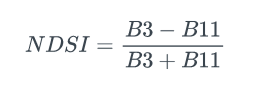

In [28]:
glacier_area = []

# let i take values from 0 to half of the source list length 
for i in range(len(out_image)//2):
    # list out_image contains clipped image bands B3 and B11 for all given years 
    # the structure of this list: [year1_B3, year1_B11, year2_B3, year2_B11, ... yearN_B3, yearN_B11]
    # that's why i iterates only "halfway through" the list
    ndsi = (out_image[i*2] - out_image[i*2+1]) / (out_image[i*2] + out_image[i*2+1])
    
    #Reklasifikace todo - Zjistit tresholdy
    """ ndsi[(ndsi >= 0.3) & (ndsi <= 0.6)] = 1.0
    ndsi[(ndsi < 0.3) & (ndsi > 0.6)] = 0.0 """

    """ ndsi[(ndsi > 0.6)] = 0.0
    ndsi[(ndsi >= 0.3) & (ndsi <= 0.6)] = 1.0
    ndsi[(ndsi < 0.3)] = 0.0 """

    """ ndsi[(ndsi > 0.5)] = 1.0
    ndsi[(ndsi <= 0.5)] = 0.0 """

    # reclassification: pixels with NDSI greater than 0.42 are assigned value 1 = glacier pixels, the rest is assigned value 0 = no glacier pixels
    ndsi[(ndsi > 0.42)] = 1.0
    ndsi[(ndsi <= 0.42)] = 0.0

    # glacier area calculation: count the number of pixels classified as glacier
    # this number is multiplied by the pixel size, in this case 400 m2, because the image bands have 20 m spatial resolution (20x20=400)
    # then it's divided by 1 million so the final glacier size is in km2
    ledovecpix = np.sum(ndsi == 1.0)
    glacier_area.append((ledovecpix*400)/1000000)
    datum = unique_dates[i]
    print(f"glacier area on {datum[6:] + '.' + datum[4:6] + '.' + datum[:4]}: {glacier_area[i]} km²")

    # save calculated NDSI as a raster file named ndsi_date.tif
    with rasterio.open(wd + f'/ndsi_{unique_dates[i]}.tif', 'w', **out_meta[i*2+1]) as dst:
        dst.write(ndsi)

glacier area on 01.07.2018: 12.5324 km²
glacier area on 16.07.2019: 11.8976 km²
glacier area on 13.07.2020: 9.1032 km²
glacier area on 18.07.2021: 11.722 km²
glacier area on 13.07.2022: 8.21 km²


<ipython-input-28-d1ceb9a82e8e>:8: RuntimeWarning: invalid value encountered in divide
  ndsi = (out_image[i*2] - out_image[i*2+1]) / (out_image[i*2] + out_image[i*2+1])


In [31]:
#Rozdil prvni minus posledni
# calculate the difference in glacier area between the first year and last year
difference = glacier_area[0]-glacier_area[len(glacier_area)-1]
if difference > 0:
    print(f"the glacier has shrunk by {difference} km²")
elif difference < 0:
    print(f"the glacier has increased by {abs(difference)} km²")
else:
    print("the glacier hasn't change")

the glacier has shrunk by 4.3224 km²


In [35]:
# Příklad data (roky a hodnoty)
years = []
values = []
for i in range (len(unique_dates)):
    years.append(unique_dates[i][:4])
    values.append(glacier_area[i])

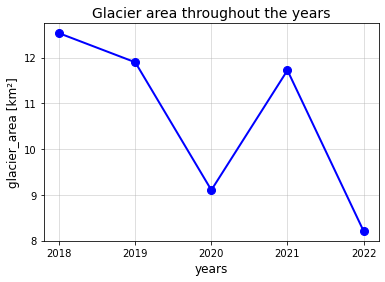

In [38]:
plt.plot(years, values, '-o', color='blue', linewidth=2, markersize=8)

# Nastavení popisků os a velikosti písma
plt.xlabel('years', fontsize=12)
plt.ylabel('glacier_area [km²]', fontsize=12)

# Přidání nadpisu
plt.title('Glacier area throughout the years', fontsize=14)

# grid
plt.grid(alpha=0.4)

# Zobrazení grafu
plt.show()